# Modeling - First Pass

## Setup

### Installs, Packages, Seeds

In [ ]:
# %pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=416c25229c548ff1266d941d716823855bcf5a4888438d7ae5c0fc8b4f6aebde
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [1]:
%pip install torch
%pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
# from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'torch'

In [4]:
# import matplotlib as mpl
# print(mpl.get_cachedir())

/home/ec2-user/.cache/matplotlib


In [2]:
# Set Seeds
seed = 99 # go Aaron Judge!
np.random.seed(seed)
torch.cuda.manual_seed(seed)


# Logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

### Mount to Google drive to connect to data

In [5]:
# drive.mount('/drive') 
# %cd /drive/MyDrive/W210 - Capstone/

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/.shortcut-targets-by-id/1oLqejM9KnDiIgUupEGkxGM3_vdqboxlI/W210 - Capstone


In [5]:
HOME = '/home/ec2-user/SageMaker/teledermatologyAI_capstone'

In [19]:
# cd $HOME/Data

/home/ec2-user/SageMaker/teledermatologyAI_capstone/Data


In [20]:
# data_dir = '/Data/'

## Data

### Load in full_csv which has all of the image paths

In [3]:
split = 'split_2'
cl = 'label_0'

In [6]:
dev_state = False
dev_sample = 15000

data = pd.read_csv(HOME + '/full_data.csv', index_col = 0).rename(columns = {'duplicated': 'duplicate', 
                                                                             'class':'label_0', 
#                                                                                'class':'label', 
                                                                             'dataset':'split_0'
                                                                            })
# data = data[data[cl] != 'Autoimmue Disorder']
data = data[data[split].isna() == False]
data['label_idx'] = pd.Categorical(data[cl]).codes
# # small_data = data.sample(n = dev_sample, random_state = seed)
# # data.rename(columns = {'dataset':'split_0', split:'dataset'}, inplace = True)
data.rename(columns = {split:'dataset'}, inplace = True)




In [7]:
data.columns

Index(['image_id', 'diagnosis', 'age', 'sex', 'localization', 'source',
       'severity', 'path', 'label_0', 'duplicate', 'split_0', 'split_1',
       'dataset', 'split_3', 'label_1', 'label_2', 'label_3', 'split_4',
       'split_5', 'split_6', 'label_idx'],
      dtype='object')

In [8]:
data[data['dataset'].isna() == False]['label_0'].value_counts()

Benign Marking or Mole                                17882
Toxin, Fungal, Bug, Viral, or Bacterial Infections     6468
Non-Cancerous Skin Condition                           4636
Unclassified                                           4105
Potentially Malignant Skin Tumors                      3604
Name: label_0, dtype: int64

In [57]:
# data = pd.read_csv(data_dir + 'full_data.csv', index_col = 0).rename(columns = {'duplicated': 'duplicate', 'class':'label'})
# data = data[data['label'] != 'Autoimmue Disorder']
# data['label_idx'] = pd.Categorical(data['label']).codes

# data.rename(columns = {'dataset': 'split_0'}, inplace = True)
# data.rename(columns = {'split_2': 'dataset'}, inplace = True)



In [58]:
data['label_0'].value_counts()

Benign Marking or Mole                                17882
Toxin, Fungal, Bug, Viral, or Bacterial Infections     6468
Non-Cancerous Skin Condition                           4636
Unclassified                                           4105
Potentially Malignant Skin Tumors                      3604
Name: label_0, dtype: int64

In [59]:
data.columns

Index(['image_id', 'diagnosis', 'age', 'sex', 'localization', 'source',
       'severity', 'path', 'label_0', 'duplicate', 'split_0', 'split_1',
       'dataset', 'split_3', 'label_idx'],
      dtype='object')

In [9]:
a = data[[cl, 'label_idx']]
a.drop_duplicates()

,label_0,label_idx
591,Benign Marking or Mole,0
5501,Potentially Malignant Skin Tumors,2
13070,Unclassified,4
46826,Non-Cancerous Skin Condition,1
46830,"Toxin, Fungal, Bug, Viral, or Bacterial Infect...",3


In [61]:
if dev_state:
  data = small_data

### Get our final train and test sets

In [10]:
train_df = data[data.dataset == 'train'].reset_index(drop = True)
val_df = data[data.dataset == 'val'].reset_index(drop = True)
test_df = data[data.dataset == 'test'].reset_index(drop = True)

In [63]:
# rem = test_df[test_df['label_0'] == 'Unclassified'].sample(frac = .75)['image_id']

In [64]:
# test_df = test_df[~test_df.image_id.isin(rem)]

In [65]:
# logging.info("df train"+str(df_train.shape))
# logging.info("df val"+str(df_val.shape))

## Modeling

## Setup

In [11]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
#         model_ft = models.densenet121(pretrained=use_pretrained)
        model_ft = models.densenet201(pretrained=use_pretrained)
        print(type(model_ft))
        print(feature_extract)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    elif model_name == 'efficientnet':
        model_ft = EfficientNet.from_pretrained('efficientnet-b7',num_classes=num_classes)
        set_parameter_requires_grad(model_ft, feature_extract)

#         # Handle the primary net
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 600

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

Set up the GPU

In [12]:
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


In [105]:
a = len(data[data.dataset.isna() == False][cl].unique())
print(a)

5


In [16]:
len(data[cl].unique())

5

In [37]:
# See notes in ln 498-500: https://github.com/abajaj25/MNIST-Skin-Cancer-with-Jetson/blob/main/notebooks/Final_Model/modeling-images-only-efficient.py
# resnet,vgg,densenet,inception
model_name = 'resnet' # 'efficientnet'
# num_classes = a
num_classes = len(data[cl].unique())
# num_classes = 6
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# # Define the device:
device = torch.device('cuda:0')
# # Put the model on the device:
model = model_ft.to(device)

Transforms

In [72]:
# torch.cuda.empty_cache()

In [73]:
# # using torch vision 'transforms'
# train_transform = transforms.Compose([
#                                         transforms.Resize((input_size,input_size)),
#                                     #   transforms.RandomHorizontalFlip(),
#                                     #   transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
#                                     #   transforms.RandomCrop(size=(input_size,input_size)),
# #                                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2),
# #                                       transforms.RandomAdjustSharpness(sharpness_factor=2),
# #                                       transforms.RandomSolarize(threshold=192.0),
# #                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#                                         transforms.ToTensor(), 
#                                     #   transforms.Normalize(norm_mean, norm_std)
#                                       ])
# # define the transformation of the val images.
# val_transform = transforms.Compose([
#                                     transforms.Resize((input_size,input_size)), 
#                                     transforms.ToTensor(),
#                                     # transforms.Normalize(norm_mean, norm_std)
#                                     ])

In [38]:
# using torch vision 'transforms'
train_transform = transforms.Compose([
                                        transforms.Resize(255),
                                        transforms.CenterCrop(224), #224
                                    #   transforms.RandomHorizontalFlip(),
                                    #   transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                    #   transforms.RandomCrop(size=(input_size,input_size)),
#                                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2),
#                                       transforms.RandomAdjustSharpness(sharpness_factor=2),
#                                       transforms.RandomSolarize(threshold=192.0),
#                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                      ])
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                        transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

Pytorch Data Loader

In [39]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index]).convert('RGB')
        
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [40]:
# Only selecting the columns we need from train and val

In [41]:
# Image.open(train['path'][0])

In [42]:
model_cols = ['path', cl, 'label_idx']
# model_cols = ['path', 'label', 'label_idx']

In [43]:
model_cols

['path', 'label_0', 'label_idx']

In [44]:
# next(iter(train_loader))

In [45]:
train_df = train_df[model_cols].reset_index(drop = True)
val_df = val_df[model_cols].reset_index(drop = True)
test_df = test_df[model_cols].reset_index(drop = True)

In [46]:
test_df

,path,label_0,label_idx
0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
1,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
2,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
3,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
4,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
...,...,...,...
6103,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2
6104,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2
6105,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2
6106,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2


In [47]:
training_set = HAM10000(train_df, transform = train_transform)
train_loader = DataLoader(training_set, batch_size= 64, 
                          shuffle=True, num_workers=24)

val_set = HAM10000(val_df, transform = val_transform)
val_loader = DataLoader(val_set, batch_size= 64, 
                          shuffle=False, num_workers=24)

test_set = HAM10000(test_df, transform = val_transform)
test_loader = DataLoader(test_set, batch_size= 64, 
                          shuffle=False, num_workers=24)


In [48]:
# Set model params
optimizer = optim.SGD(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss().to(device)

Class to Track metrics during training

In [49]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Define train function

In [50]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)

    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
#         if (i + 1) % 1 == 0:
            print(f'[epoch {epoch}], [iter {i+1} of {len(train_loader)}],[train loss {train_loss.avg:.5f}], [train acc {train_acc.avg:.5f}]')
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg
    print('finished train data load')

Define val function

In [51]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print(f'[epoch {epoch}], [val loss {val_loss.avg:.5f}], [val acc {val_acc.avg:.5f}]')
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [52]:
def test(test_loader, model):
    model.eval()
    true_labels = []
    predictions_out = []

    test_loss = AverageMeter()
    test_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            # Save test output
            predictions_out.append(prediction.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

            test_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            test_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print(f'[test loss {test_loss.avg:.5f}], [test acc {test_acc.avg:.5f}]')
    print('------------------------------------------------------------')
    return test_loss.avg, test_acc.avg, predictions_out, true_labels

Run the model

In [27]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


## Train Sequence

In [ ]:
model_name = 'resnet_split3_10e'
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
print("Starting Training")
total_since = time.time()
for epoch in range(1, epoch_num+1):

    # timing
    since = time.time()

    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model, f'{HOME}/model/{model_name}.pt')
    
    time_elapsed = time.time() - since

    print('\nEPOCH', epoch, ":")
    print('*****************************************************')
    print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
    print('*****************************************************')
    # print(logging.info('*****************************************************'))
    # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
    # print(logging.info('*****************************************************'))

total_time_elapsed = time.time() - total_since
print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 211],[train loss 0.86845], [train acc 0.66266]
[epoch 1], [iter 200 of 211],[train loss 0.87069], [train acc 0.66195]
------------------------------------------------------------
[epoch 1], [val loss 0.93835], [val acc 0.62185]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 21s
best record: [epoch 1], [val loss 0.93835], [val acc 0.62185]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.81571], [train acc 0.68391]
[epoch 2], [iter 200 of 211],[train loss 0.81833], [train acc 0.68383]
------------------------------------------------------------
[epoch 2], [val loss 0.91328], [val acc 0.64147]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 2m 22s
best record: [epoch 2], [val loss 0.91328], [val acc 0.64147]
**********

### Previous Runs

In [ ]:
# model_name = 'resnet_split6_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 407],[train loss 1.02624], [train acc 0.55844]
[epoch 1], [iter 200 of 407],[train loss 0.93912], [train acc 0.59344]
[epoch 1], [iter 300 of 407],[train loss 0.89546], [train acc 0.61354]
[epoch 1], [iter 400 of 407],[train loss 0.86916], [train acc 0.62281]
------------------------------------------------------------
[epoch 1], [val loss 0.77504], [val acc 0.65644]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 6m 24s
best record: [epoch 1], [val loss 0.77504], [val acc 0.65644]
*****************************************************
[epoch 2], [iter 100 of 407],[train loss 0.76852], [train acc 0.66734]
[epoch 2], [iter 200 of 407],[train loss 0.75025], [train acc 0.67555]
[epoch 2], [iter 300 of 407],[train loss 0.74472], [train acc 0.67708]
[epoch 2], [iter 400 of 407],[train loss 0.74002], [train acc 0.67805]
-------------------------------------------

In [ ]:
# model_name = 'resnet_split1_3e_2'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 673],[train loss 1.07625], [train acc 0.59188]
[epoch 1], [iter 200 of 673],[train loss 0.90003], [train acc 0.66984]
[epoch 1], [iter 300 of 673],[train loss 0.81836], [train acc 0.70297]
[epoch 1], [iter 400 of 673],[train loss 0.76176], [train acc 0.72340]
[epoch 1], [iter 500 of 673],[train loss 0.72130], [train acc 0.73769]
[epoch 1], [iter 600 of 673],[train loss 0.69296], [train acc 0.74628]
------------------------------------------------------------
[epoch 1], [val loss 0.50842], [val acc 0.81475]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 20m 51s
best record: [epoch 1], [val loss 0.50842], [val acc 0.81475]
*****************************************************
[epoch 2], [iter 100 of 673],[train loss 0.52767], [train acc 0.79797]
[epoch 2], [iter 200 of 673],[train loss 0.51501], [train acc 0.80391]
[epoch 2], [iter 300 of 673],[train loss 0

In [ ]:
# model_name = 'resnet_split1_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 658],[train loss 0.96839], [train acc 0.62906]
[epoch 1], [iter 200 of 658],[train loss 0.80823], [train acc 0.69703]
[epoch 1], [iter 300 of 658],[train loss 0.73678], [train acc 0.72479]
[epoch 1], [iter 400 of 658],[train loss 0.68474], [train acc 0.74422]
[epoch 1], [iter 500 of 658],[train loss 0.65381], [train acc 0.75503]
[epoch 1], [iter 600 of 658],[train loss 0.62744], [train acc 0.76375]
------------------------------------------------------------
[epoch 1], [val loss 0.44100], [val acc 0.83620]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 20m 10s
best record: [epoch 1], [val loss 0.44100], [val acc 0.83620]
*****************************************************
[epoch 2], [iter 100 of 658],[train loss 0.45512], [train acc 0.82016]
[epoch 2], [iter 200 of 658],[train loss 0.44669], [train acc 0.82359]
[epoch 2], [iter 300 of 658],[train loss 0

In [ ]:
# model_name = 'resnet_split3_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
# model_name = 'resnet_15k_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
# model_name = 'model_resnet_full'
# epoch_num = 5
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
best_val_acc

0.8642676767676767

In [ ]:
# model_name = 'resnet_split2_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
# model_name = 'resnet_split4_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 413],[train loss 1.12460], [train acc 0.53844]
[epoch 1], [iter 200 of 413],[train loss 1.04662], [train acc 0.57508]
[epoch 1], [iter 300 of 413],[train loss 1.00262], [train acc 0.59214]
[epoch 1], [iter 400 of 413],[train loss 0.97493], [train acc 0.60191]
------------------------------------------------------------
[epoch 1], [val loss 0.86524], [val acc 0.64597]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 8m 24s
best record: [epoch 1], [val loss 0.86524], [val acc 0.64597]
*****************************************************
[epoch 2], [iter 100 of 413],[train loss 0.85078], [train acc 0.65031]
[epoch 2], [iter 200 of 413],[train loss 0.83847], [train acc 0.65703]
[epoch 2], [iter 300 of 413],[train loss 0.83400], [train acc 0.65781]
[epoch 2], [iter 400 of 413],[train loss 0.82715], [train acc 0.66059]
-------------------------------------------

In [ ]:
# model_name = 'resnet_split5_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 407],[train loss 1.11664], [train acc 0.55016]
[epoch 1], [iter 200 of 407],[train loss 1.04299], [train acc 0.57742]
[epoch 1], [iter 300 of 407],[train loss 0.99161], [train acc 0.59771]
[epoch 1], [iter 400 of 407],[train loss 0.95636], [train acc 0.61234]
------------------------------------------------------------
[epoch 1], [val loss 0.85869], [val acc 0.64691]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 6m 25s
best record: [epoch 1], [val loss 0.85869], [val acc 0.64691]
*****************************************************
[epoch 2], [iter 100 of 407],[train loss 0.84339], [train acc 0.65844]
[epoch 2], [iter 200 of 407],[train loss 0.81449], [train acc 0.66906]
[epoch 2], [iter 300 of 407],[train loss 0.80659], [train acc 0.67370]
[epoch 2], [iter 400 of 407],[train loss 0.79864], [train acc 0.67578]
-------------------------------------------

In [ ]:
# model_name = 'resnet_split2_3e_3'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 399],[train loss 1.03736], [train acc 0.58719]
[epoch 1], [iter 200 of 399],[train loss 0.96636], [train acc 0.61328]
[epoch 1], [iter 300 of 399],[train loss 0.91827], [train acc 0.63292]
------------------------------------------------------------
[epoch 1], [val loss 0.79988], [val acc 0.67414]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 1m 49s
best record: [epoch 1], [val loss 0.79988], [val acc 0.67414]
*****************************************************
[epoch 2], [iter 100 of 399],[train loss 0.77942], [train acc 0.68063]
[epoch 2], [iter 200 of 399],[train loss 0.77658], [train acc 0.68680]
[epoch 2], [iter 300 of 399],[train loss 0.77319], [train acc 0.68766]
------------------------------------------------------------
[epoch 2], [val loss 0.75023], [val acc 0.69222]
------------------------------------------------------------

EPOCH 2 :
***

## Test/Eval

In [ ]:
# model_name = 'model_resnet_full'

In [ ]:

# # model_in = torch.load(f'./Models/{model_name}.pth')
# model.load_state_dict(torch.load(f'./Models/{model_name}.pth'))

In [100]:
# model_name = 'resnet_split2_3e'
# model_name = 'resnet_split7_3e'

In [68]:
model_name = 'resnet_split3_10e'

In [69]:
# torch.save(model, './Models/test.pt')
# model_in = torch.load('./Models/model_resnet_full.pt')
model_in = torch.load(f'./model/{model_name}.pt')

In [69]:
test_df.label_idx.value_counts()

4    2882
0    1776
3     638
1     462
2     350
Name: label_idx, dtype: int64

In [70]:
loss_test, acc_test, preds, labs = test(test_loader, model_in)

------------------------------------------------------------
[test loss 0.42915], [test acc 0.85363]
------------------------------------------------------------


In [72]:
true_labels = np.array(list(itertools.chain(*labs)))
predictions = np.array(list(itertools.chain(*preds)))

In [73]:
correct = (true_labels == predictions.flatten())
accur = correct.sum() / correct.size
accur

0.8529796987557302

In [74]:
cl = 'label_0'

In [75]:
labels_idx = np.sort(data.label_idx.unique())
label_map = data[[cl, 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map[cl]))

In [76]:
labs = pd.Series(true_labels).map(label_dict)
preds = pd.Series(predictions.flatten()).map(label_dict)
labels = pd.Series(labels_idx).map(label_dict)

In [77]:
pred_df = pd.concat([labs, 
           preds, 
           pd.Series(true_labels), 
           pd.Series(predictions.flatten())], axis = 1)\
           .rename(columns = {0:'lab', 1: 'pred', 2: 'lab_idx', 3: 'pred_idx'})

In [78]:
model_name

'resnet_split3_10e'

In [ ]:
pred_df.to_pickle(f'./Models/{model_name}_preds.pkl')

In [ ]:
d = pd.read_pickle(f'./Models/{model_name}_preds.pkl')

In [63]:
def plot_confusion(labels, predictions, normalize = True): 
    
    if normalize:
        norm = 'true'
        fmt = '.1%'
    else: 
        norm = None
        fmt = 'g'

    labs_unique = np.sort(labels.unique())

    c_matrix = confusion_matrix(labels, predictions, normalize = norm)
    plt.title("Confusion matrix")
    sns.heatmap(c_matrix, cmap='Blues', annot=True, 
                xticklabels=labs_unique, yticklabels=labs_unique, 
                fmt=fmt, cbar=True)
    plt.xlabel('predictions')
    plt.ylabel('true labels')
    plt.show()

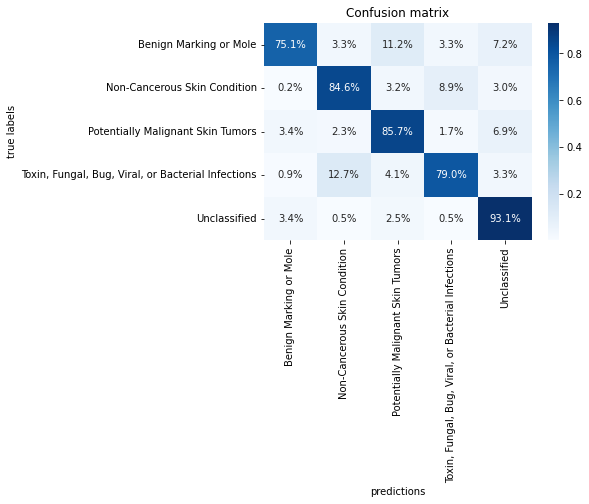

In [79]:
# split 3e_2
plot_confusion(labs, preds, True)

In [ ]:
test_df

,path,label,label_idx
0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
1,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
2,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
3,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
4,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,0
...,...,...,...
6103,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2
6104,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2
6105,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2
6106,./Data/dermnet/train/Melanoma Skin Cancer Nevi...,Potentially Malignant Skin Tumors,2


In [ ]:
test_df.label_idx.value_counts(
)

0    1742
4     723
3     639
1     458
2     319
Name: label_idx, dtype: int64

In [ ]:
train_df.label_idx.value_counts()


0    13450
3     4857
1     3482
2     2258
4     1042
Name: label_idx, dtype: int64

In [ ]:
train_df.label_0.value_counts()

Benign Marking or Mole                                13450
Toxin, Fungal, Bug, Viral, or Bacterial Infections     4857
Non-Cancerous Skin Condition                           3482
Potentially Malignant Skin Tumors                      2258
Unclassified                                           1042
Name: label_0, dtype: int64